In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

In [2]:
returns = pd.read_csv('returns_for_gan.csv')

In [3]:
returns.head()

,Date,BetaShares Gold Bullion Currency Hedged,Vanguard Australian Shares,iShares S&P/ASX Dividend Opportunities,Ishares Core S&P/Asx 200,Vanguard Australian Property Securities,Vanguard Australian Shares High Yield,ETFS Physical Gold,BetaShares US Dollar,Vanguard All World Ex US Shares,...,Ennakl Automobiles SA,Poulina Group Holding,Societe Frigorifique Et Brasserie,Societe Moderne De Ceramique,Société Tunisienne d'Entreprises de Télécommunication,Societe Tunisienne De L'Air,Telnet Holding,Societe Tunisie Profiles Aluminium,Union Internationale De Banques,Societe Tunisienne De Verreries
0,2011-12-02,-0.001142,0.011482,0.000000,0.013609,0.002134,0.009771,-0.001932,0.003093,-0.002933,...,0.008772,0.007143,-0.001692,-0.041436,0.014516,0.000000,0.007865,0.008264,-0.003214,0.026940
1,2011-12-05,0.001144,0.011712,0.000000,0.009667,0.014696,0.018118,0.002480,0.002055,0.011275,...,-0.010870,-0.009456,0.001695,0.020173,-0.006359,-0.005917,-0.006689,-0.004918,0.000000,-0.014690
2,2011-12-06,-0.018846,-0.012823,-0.014085,-0.014894,-0.000840,-0.006269,-0.013820,0.004103,-0.003878,...,-0.005495,-0.021480,-0.018613,0.002825,0.006400,-0.005952,-0.012346,-0.011532,-0.000537,-0.001065
3,2011-12-07,0.011059,0.003608,0.005714,0.009719,-0.005882,0.000407,-0.000857,-0.010215,0.000000,...,0.019890,0.000000,0.017241,0.000000,-0.014308,0.005988,0.018182,0.000000,0.000000,0.002132
4,2011-12-08,0.004606,0.000539,-0.005682,-0.002139,-0.000845,0.000000,0.005022,0.001032,0.006083,...,-0.002167,-0.006098,0.002542,0.000000,-0.009677,0.011905,-0.017857,0.008333,-0.001613,-0.001064


In [4]:
returns.shape

(2500, 14611)

In [5]:
returns_sample = returns.iloc[:, :500]
returns_sample.drop(['Date'], axis=1, inplace=True)

In [128]:
class Denoising:
    
    def __init__(self, returns: pd.DataFrame, n_facts: int, alpha: float, b_width: float = .01):
        
        self._returns = returns
        self._n_facts = n_facts
        self._alpha = alpha
        self._b_width = b_width
        self._n_points = returns.shape[0]
        
        self._q = returns.shape[0] / float(returns.shape[1])
        
        self.cov_matrix = np.corrcoef(returns, rowvar = 0)
        
        self.e_val, self.e_vec = self._get_pca()
        
    def remove_noise_with_mean(self):
        
        max_eval, variance = self._find_max_eval()
        
        n_facts = self.e_val.shape[0] - np.diag(self.e_val)[::-1].searchsorted(max_eval)
        
        corr_matrix = self._filter_mean(self.e_val, self.e_vec, n_facts)
        
        return corr_matrix
    
    def remove_noise_with_shrinkage(self):
        
        max_eval, variance = self._find_max_eval()
        
        n_facts = self.e_val.shape[0] - np.diag(self.e_val)[::-1].searchsorted(max_eval)
        
        corr_matrix = self._filter_shrinkage(self.e_val, self.e_vec, n_facts, alpha = self._alpha)
        
        return corr_matrix
        
        
    def _filter_mean(self, eVal, eVec, nFacts):
        """Substitui ruído pela média
        """
        # Remove noise from corr by fixing random eigenvalues
        eVal_ = np.diag(eVal).copy()
        # aqui esta substituindo tudo que eh ruido pela media dos ruidos
        eVal_[nFacts:] = eVal_[nFacts:].sum()/float(eVal_.shape[0]-nFacts) 
        eVal_ = np.diag(eVal_)
        # calculate corr matrix with eVec and eVal
        # convertendo de autovetores para matrix de correlacao novamente
        corr1 = np.dot(eVec, eVal_).dot(eVec.T)
        corr1 = Denoising.cov2corr(corr1)
        return corr1
    
    def _filter_shrinkage(self, eVal, eVec, nFacts, alpha = 0):

        eValL, eVecL = eVal[:nFacts, :nFacts], eVec[:, :nFacts] 
        eValR, eVecR = eVal[nFacts:, nFacts:], eVec[:, nFacts:]
        
        corr_left = np.dot(eVecL, eValL).dot(eVecL.T)
        corr_right = np.dot(eVecR, eValR).dot(eVecR.T)
        
        corr_shrinkage = corr_left + alpha * corr_right + (1 - alpha) * np.diag(np.diag(corr_right))
        
        return corr_shrinkage

    def _get_pca(self):
        """
        Function that gets eigenvalues and eigenvectors
        of a given Hermitian matrix
        
        Args:
            - matrix (pd.DataFrame or np.array)
        Returns:
            - (tuple) eigenvalues (matrix), eigenvectors (matrix)
        """
        e_val, e_vec = np.linalg.eigh(self.cov_matrix)

        indices = e_val.argsort()[::-1]

        e_val, e_vec = e_val[indices], e_vec[:,indices]
        e_val = np.diagflat(e_val)
        
        return e_val, e_vec


    def _find_max_eval(self):
        
        out = minimize(lambda var: self._compare_theoretical_and_empirical(var),
                       x0=np.array(0.5), bounds=((1E-5, 1-1E-5),))

        if out['success']: var = out['x'][0]
        else: var=1
            
        eMax = var*(1+(1./self._q)**.5)**2
        
        return eMax, var
    
    def _compare_theoretical_and_empirical(self, var):
                
        theoretical_pdf = Denoising.marcenko_pastur_pdf(var[0], self._q, self._n_points) 
        empirical_pdf = Denoising.fit_kde(np.diag(self.e_val), self._b_width, x = theoretical_pdf.index.values)
        
        mean_squared_errors = np.sum((empirical_pdf - theoretical_pdf)**2)
        
        return mean_squared_errors

    @staticmethod
    def fit_kde( obs, b_width = .25, kernel = "gaussian", x = None):
        """Fit kernel to a series of obs, and derive the prob of obs
        Args:
            - obs (np.array): array with eingenvalues sorted desc
            - bWidth (float): 
            - kernel (str): type of kernel to apply on KDE method
            - x (np.array or None): array of values on which the fit KDE will be evaluated
        Returns:
            - (pd.Series) estimated density function
        """
        
        if len(obs.shape)==1:
            obs = obs.reshape(-1,1)
            
        kde = KernelDensity(kernel = kernel, bandwidth = b_width).fit(obs)
        
        if x is None: 
            x = np.unique(obs)
            
        if len(x.shape) == 1: 
            x = x.reshape(-1,1)
        
        logProb = kde.score_samples(x) # log(density)
        pdf = pd.Series(np.exp(logProb), index = x.flatten())
        
        return pdf
    
    @staticmethod
    def marcenko_pastur_pdf(var, q, pts):
        """Generates random variable with Marcenko-pastur
        distribuition
        Args:
            - var (float): variance
            - q (float): T/N, where T and N are the dimensions of a matrix
            - pts (int): number of points to generate
        Returns: 
            - (pd.Series) generated random variables
        """
        # eMin and eMax are the minimum and maximum eigenvalues
        eMin, eMax = var*(1-(1./q)**.5)**2, var*(1+(1./q)**.5)**2
        # eVal is an array with length of pts between eMin and eMax
        eVal = np.linspace(eMin, eMax, pts)
        # calculates probability function for eVal
        pdf = q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
        # converts to pd.Series
        pdf = pd.Series(pdf, index = eVal)
        return pdf 
    
    @staticmethod
    def cov2corr(cov):
        # Derive the correlation matrix from a covariance matrix
        std = np.sqrt(np.diag(cov))
        corr = cov / np.outer(std, std)
        corr[corr < -1] ,corr[corr > 1] = -1, 1 # numerical error
        return corr

In [144]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

class Denoising:
    
    def __init__(self, returns: pd.DataFrame, n_facts: int, alpha: float, b_width: float = .01):
        
        self._returns = returns
        self._n_facts = n_facts
        self._alpha = alpha
        self._b_width = b_width
        self._n_points = returns.shape[0]
        
        self._q = returns.shape[0] / float(returns.shape[1])
        
        self.cov_matrix = np.corrcoef(returns, rowvar = 0)
        
        self.e_val, self.e_vec = self._get_pca()
        
    def remove_noise_with_mean(self):
        
        max_eval, variance = self._find_max_eval()
        
        n_facts = self.e_val.shape[0] - np.diag(self.e_val)[::-1].searchsorted(max_eval)
        
        corr_matrix = self._filter_mean(n_facts)
        
        return corr_matrix
    
    def remove_noise_with_shrinkage(self):
        
        max_eval, variance = self._find_max_eval()
        
        n_facts = self.e_val.shape[0] - np.diag(self.e_val)[::-1].searchsorted(max_eval)
        
        corr_matrix = self._filter_shrinkage(self.e_val, self.e_vec, n_facts, alpha = self._alpha)
        
        return corr_matrix
        
        
    def _filter_mean(self, n_facts):
        """Substitui ruído pela média
        """

        e_val = np.diag(self.e_val).copy()

        e_val[n_facts:] = e_val[n_facts:].sum()/float(e_val.shape[0] - n_facts) 
        e_val = np.diag(e_val)

        cov = np.dot(self.e_vec, e_val).dot(self.e_vec.T)
        corr = Denoising.cov2corr(cov)

        return corr
    
    def _filter_shrinkage(self, eVal, eVec, nFacts, alpha = 0):

        e_val_left  = self.e_val[:n_facts, :n_facts]
        e_vec_left = self.e_vec[:, :n_facts] 
        e_val_right, e_vec_right = self.e_val[n_facts:, n_facts:], self.e_vec[:, n_facts:]
        
        corr_left = np.dot(e_vec_left, e_val_left).dot(e_vec_left.T)
        corr_right = np.dot(e_vec_right, e_val_right).dot(e_vec_right.T)
        
        corr_shrinkage = corr_left + alpha * corr_right + (1 - alpha) * np.diag(np.diag(corr_right))
        
        return corr_shrinkage

    def _get_pca(self):
        """
        Function that gets eigenvalues and eigenvectors
        of a given Hermitian matrix
        
        Args:
            - matrix (pd.DataFrame or np.array)
        Returns:
            - (tuple) eigenvalues (matrix), eigenvectors (matrix)
        """
        e_val, e_vec = np.linalg.eigh(self.cov_matrix)

        indices = e_val.argsort()[::-1]

        e_val, e_vec = e_val[indices], e_vec[:,indices]
        e_val = np.diagflat(e_val)
        
        return e_val, e_vec


    def _find_max_eval(self):
        
        out = minimize(lambda var: self._compare_theoretical_and_empirical(var),
                       x0=np.array(0.5), bounds=((1E-5, 1-1E-5),))

        if out['success']: var = out['x'][0]
        else: var=1
            
        e_max = var*(1+(1./self._q)**.5)**2
        
        return e_max, var
    
    def _compare_theoretical_and_empirical(self, var):
                
        theoretical_pdf = Denoising.marcenko_pastur_pdf(var[0], self._q, self._n_points) 
        empirical_pdf = Denoising.fit_kde(np.diag(self.e_val), self._b_width, x = theoretical_pdf.index.values)
        
        mean_squared_errors = np.sum((empirical_pdf - theoretical_pdf)**2)
        
        return mean_squared_errors

    @staticmethod
    def fit_kde( obs, b_width = .25, kernel = "gaussian", x = None):
        """Fit kernel to a series of obs, and derive the prob of obs
        Args:
            - obs (np.array): array with eingenvalues sorted desc
            - bWidth (float): 
            - kernel (str): type of kernel to apply on KDE method
            - x (np.array or None): array of values on which the fit KDE will be evaluated
        Returns:
            - (pd.Series) estimated density function
        """
        
        if len(obs.shape)==1:
            obs = obs.reshape(-1,1)
            
        kde = KernelDensity(kernel = kernel, bandwidth = b_width).fit(obs)
        
        if x is None: 
            x = np.unique(obs)
            
        if len(x.shape) == 1: 
            x = x.reshape(-1,1)
        
        logProb = kde.score_samples(x) # log(density)
        pdf = pd.Series(np.exp(logProb), index = x.flatten())
        
        return pdf
    
    @staticmethod
    def marcenko_pastur_pdf(var, q, pts):
        """Generates random variable with Marcenko-pastur
        distribuition
        Args:
            - var (float): variance
            - q (float): T/N, where T and N are the dimensions of a matrix
            - pts (int): number of points to generate
        Returns: 
            - (pd.Series) generated random variables
        """
        # eMin and eMax are the minimum and maximum eigenvalues
        eMin, eMax = var*(1-(1./q)**.5)**2, var*(1+(1./q)**.5)**2
        # eVal is an array with length of pts between eMin and eMax
        eVal = np.linspace(eMin, eMax, pts)
        # calculates probability function for eVal
        pdf = q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
        # converts to pd.Series
        pdf = pd.Series(pdf, index = eVal)
        return pdf 
    
    @staticmethod
    def cov2corr(cov):
        # Derive the correlation matrix from a covariance matrix
        std = np.sqrt(np.diag(cov))
        corr = cov / np.outer(std, std)
        corr[corr < -1] ,corr[corr > 1] = -1, 1 # numerical error
        return corr

In [145]:
n_facts = 100
alpha = .995

d = Denoising(returns = returns_sample, n_facts = n_facts, alpha = alpha)

In [146]:
a = d.remove_noise_with_mean()

<AxesSubplot:>

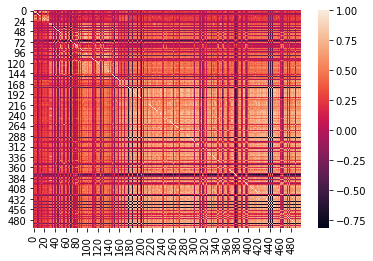

In [147]:
sns.heatmap(a)

In [148]:
b = d.remove_noise_with_shrinkage()

<AxesSubplot:>

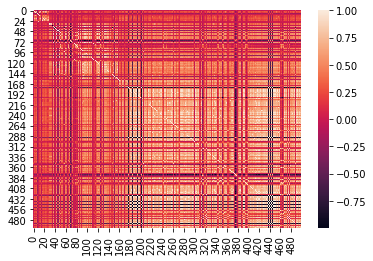

In [149]:
sns.heatmap(b)